In [13]:
pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/1f/97/dec9dfa95cfbee631adffbeb0b7eda51ddc93a5f7e8aa8f4d95dde59e69e/tensorflow-2.16.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.2 from https://files.pythonhosted.org/packages/46/87/c3e4e9fe7c630f38a6984afdd1d4ed531ef9c74dc66b86f46f6bdd89d608/tensorflow_intel-2.16.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2d

In [17]:
# imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

In [3]:
#Loading the dataset
emission = pd.read_csv('CO2_emission.csv')
original_data = pd.read_csv('CO2_emission.csv')

#Filling missing values for numerical columns with mean and categorical columns with mode
num_cols = emission.select_dtypes(include=['float64', 'int64']).columns
cat_cols = emission.select_dtypes(include=['object']).columns

num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

emission[num_cols] = num_imputer.fit_transform(emission[num_cols])
emission[cat_cols] = cat_imputer.fit_transform(emission[cat_cols])

#Filling missing values for numerical columns with mean and categorical columns with mode

num_cols2 = original_data.select_dtypes(include=['float64', 'int64']).columns
cat_cols2 = original_data.select_dtypes(include=['object']).columns

original_data[num_cols2] = num_imputer.fit_transform(original_data[num_cols2])
original_data[cat_cols2] = cat_imputer.fit_transform(original_data[cat_cols2])

#Converting categorical variables to dummy variables
emission = pd.get_dummies(emission, columns=cat_cols, drop_first=True)

#Splitting the data into features and target variable
X = emission.drop('Fuel_Consumption_comb(L/100km)', axis=1)
y = emission['Fuel_Consumption_comb(L/100km)']

#Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
#Training different models
models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

param_grids = {
    'Linear Regression': {},
    'Support Vector Regression': {'kernel': ['linear', 'rbf'], 'C': [0.01, 0.1, 1, 10, 100]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 9]}
}

best_models = {}
best_scores = {}

for model_name in models:
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    best_scores[model_name] = -grid_search.best_score_

#Selecting the best model
best_model_name = min(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

#Evaluating the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)


print(f'Best Model: {best_model_name}')
print(f'Test Mean Squared Error: {mse}')

Best Model: Support Vector Regression
Test Mean Squared Error: 0.007692922079770022


In [29]:
# Neural Network Model

def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

nn_model = create_model()

# Fitting the model
history = nn_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluating the model
nn_pred = nn_model.predict(X_test)
nn_mse = mean_squared_error(y_test, nn_pred)
print(f'Neural Network Test Mean Squared Error: {nn_mse}')

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 114.6519 - val_loss: 103.3101
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 73.2061 - val_loss: 64.4702
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.9155 - val_loss: 30.9660
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.2729 - val_loss: 30.9657
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9689 - val_loss: 29.1291
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1770 - val_loss: 27.1055
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6178 - val_loss: 27.3251
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7119 - val_loss: 27.3010
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0496 - val_loss: 25.8714
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3762 - val_loss: 24.6872
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5668 - val_loss: 24.4280
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

In [23]:
#Summary Statistics and Brief Analysis

#For numeric data
print(original_data.describe(include=np.number))
print("CO2 emissions vary significantly among vehicles, with most vehicles emitting between 213 and 303.5 grams per kilometer."
      "There are outliers with very high emissions (up to 608 grams per kilometer), indicating a right-skewed distribution.")
print("Smog levels show a broad distribution, with a median of 5. "
      "The values range from 1 to 7, suggesting most vehicles have moderate to high smog levels.")

#For categoric data
print(original_data.describe(include=object))

print("There is a high diversity in car models, with the most frequent model (Sierra 4WD) appearing only 7 times. "
      "This suggests a wide range of different car models with relatively few repetitions.")

       Model_Year  Engine_Size   Cylinders  \
count       935.0   935.000000  935.000000   
mean       2021.0     3.214866    5.716578   
std           0.0     1.388513    1.977359   
min        2021.0     1.000000    3.000000   
25%        2021.0     2.000000    4.000000   
50%        2021.0     3.000000    6.000000   
75%        2021.0     4.000000    8.000000   
max        2021.0     8.000000   16.000000   

       Fuel_Consumption_in_City(L/100 km)  \
count                          935.000000   
mean                            12.498610   
std                              3.487271   
min                              4.000000   
25%                             10.100000   
50%                             12.000000   
75%                             14.800000   
max                             30.300000   

       Fuel_Consumption_in_City_Hwy(L/100 km)  Fuel_Consumption_comb(L/100km)  \
count                              935.000000                      935.000000   
mean             

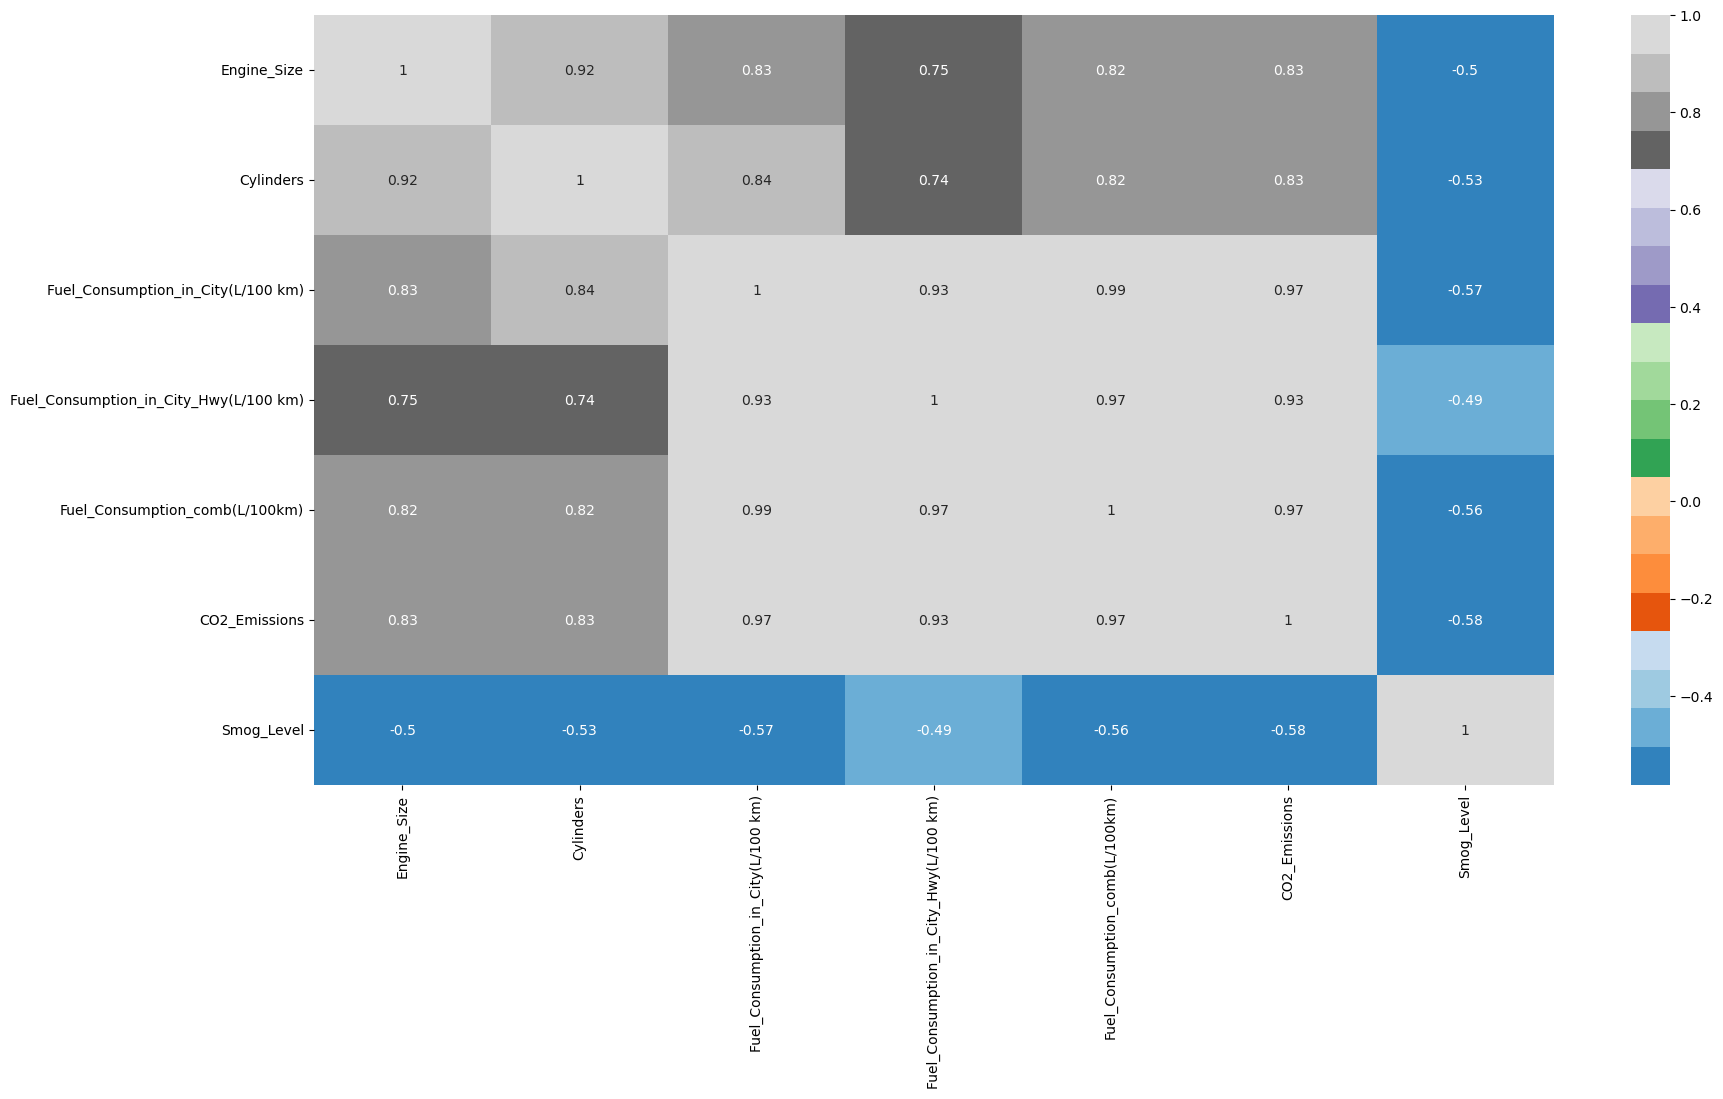

Higher fuel consumption in any mode (city, highway, or combined) is strongly correlated with higher CO2 emissions.
Higher fuel consumption in the city, highway, and combined as well as high CO2 Emissions are associated with lower smog levels.


In [6]:
#Correlation

corr_data = original_data.drop("Model_Year", axis=1)
data_num_features = corr_data.select_dtypes(include=np.number)

plt.figure(figsize=(20,10))

corr =  data_num_features.corr()

#Correlation for numeric data
corr =data_num_features.corr(method='pearson')
sns.heatmap(corr, annot=True,cmap='tab20c')
plt.show()

#Correlation Analysis

print("Higher fuel consumption in any mode (city, highway, or combined) is strongly correlated with higher CO2 emissions.")
print("Higher fuel consumption in the city, highway, and combined as well as high CO2 Emissions are associated with lower smog levels.")

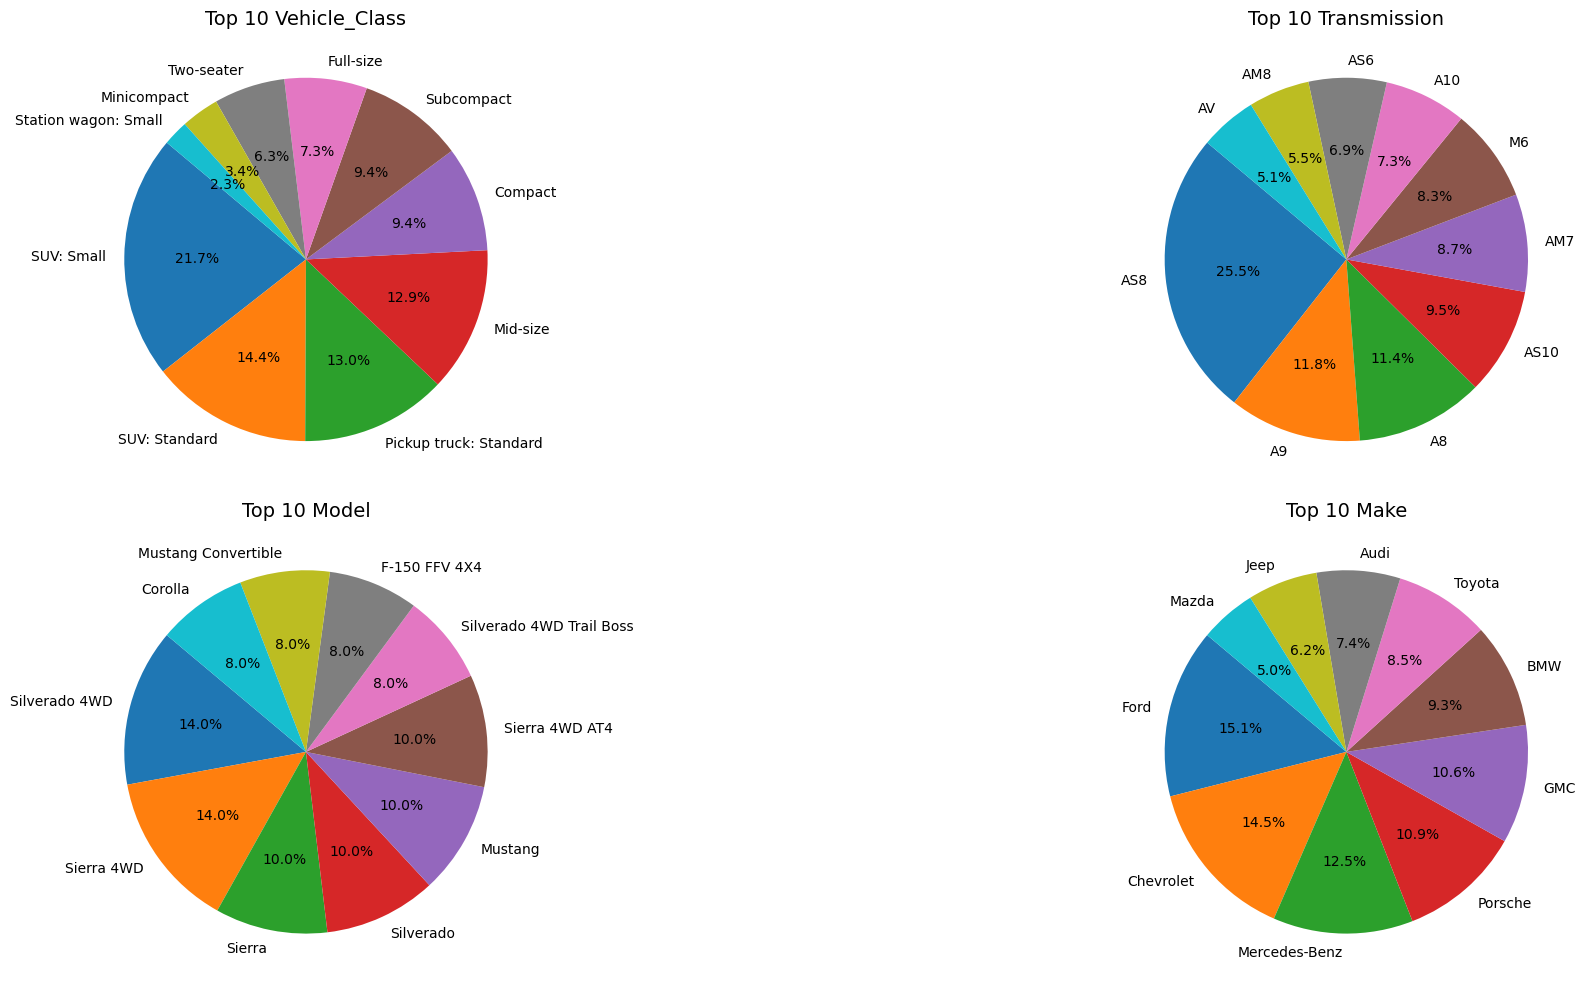

In [7]:
#Correlation for categoric data
data_cat_features = original_data.select_dtypes(include='object')
data_cat_features1 = data_cat_features[['Vehicle_Class', 'Transmission', 'Model', 'Make']]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 10))

for variable, subplot in zip(data_cat_features1.columns, ax.flatten()):
    cat_count = original_data[variable].value_counts()
    cat_count15 = cat_count[:10]

    if cat_count.size > 10:
        title = 'Top 10 {}'.format(variable)
    else:
        title = variable

    subplot.pie(cat_count15.values, labels=cat_count15.index, autopct='%1.1f%%', startangle=140)
    subplot.set_title(title, fontsize=14)


plt.tight_layout()
plt.show()

Top 10 Make: Most of the cars on the roads are made by Ford. 
Top 10 Model: Sierra 4WD and Silverado 4WD are amongst the most famous models driven. 
Top 10 Vehicle_Class: SUV-Small is the preferred class of vehicle. 
Top 10 Transmission: More than 25% of cars have AS8 transmission types. 



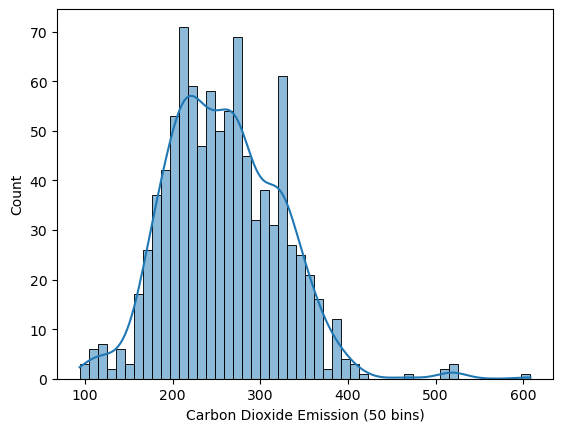

In [10]:
#Correlation Analysis
print("Top 10 Make: Most of the cars on the roads are made by Ford.", "\n"
    "Top 10 Model: Sierra 4WD and Silverado 4WD are amongst the most famous models driven.", "\n"
    "Top 10 Vehicle_Class: SUV-Small is the preferred class of vehicle.", "\n"
    "Top 10 Transmission: More than 25% of cars have AS8 transmission types.", "\n")

fig, ax = plt.subplots()

#Analyzing Target Variable

sns.histplot(original_data['CO2_Emissions'], bins=50, kde=True, ax=ax)
ax.set_xlabel('Carbon Dioxide Emission (50 bins)')

plt.show()

Mean for CO2 Emission is 258.52941176470586
Median for CO2 Emission is 255.0
Mode for CO2 Emission is 214.0


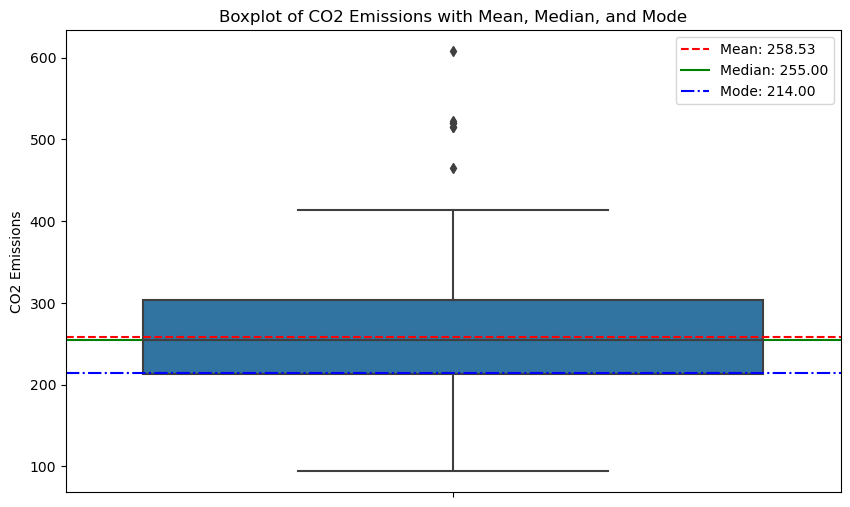

In [11]:
#Getting mean, median, and mode of CO2 Emissions and plotting on Boxplot
mean = emission['CO2_Emissions'].mean()
mode = emission['CO2_Emissions'].mode()[0]
median = emission['CO2_Emissions'].median()

print(f'Mean for CO2 Emission is {mean}')
print(f'Median for CO2 Emission is {median}')
print(f'Mode for CO2 Emission is {mode}')

fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(y=emission['CO2_Emissions'], ax=ax)

ax.axhline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
ax.axhline(median, color='g', linestyle='-', label=f'Median: {median:.2f}')
ax.axhline(mode, color='b', linestyle='-.', label=f'Mode: {mode:.2f}')

ax.legend()

ax.set_ylabel('CO2 Emissions')
ax.set_title('Boxplot of CO2 Emissions with Mean, Median, and Mode')

plt.show()

In [12]:
#Analysis of Centers of CO2 Emissions
print("Of all the three statistics, the mean is the largest, "
      "while the mode is the smallest thus CO2_Emissions is positively "
      "skewed which implies that most of the CO2 Emissions are less than "
      "the average CO2 Emissions.")

Of all the three statistics, the mean is the largest, while the mode is the smallest thus CO2_Emissions is positively skewed which implies that most of the CO2 Emissions are less than the average CO2 Emissions.
